# Tensorflow Optimization: Cats versus Dogs
Exploring optimization impact on size, performance and accuracy!

**For best performance on this Colab make sure you are using a GPU runtime!** The runtime can be changed by selecting: ```runtime -> change runtime type``` and selecting GPU from the hardware accelerator dropdown.

### We start by importing TensorFlow and our Dataset
And splitting our dataset into batches.

In [2]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# format images to have normalized pixels
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

# load in our dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# display how much data we have
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(num_examples)
print(num_classes)

# split the data in training, validation, and test datasets
BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

# display the shape of our data
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

23262
2


2025-02-26 18:25:51.928799: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([32, 224, 224, 3])

### We next define our (pre-trained) model

In [4]:
# Tested on MacOS

module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

class CustomHubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_layer.handle  # Save the URL of the Hub model
        })
        return config

    @classmethod
    def from_config(cls, config):
        hub_layer = hub.KerasLayer(config["hub_url"], trainable=False)
        return cls(hub_layer)

# Wrap feature extractor
feature_extractor = CustomHubLayer(feature_extractor)

# This works for tensorflow 2.10
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 131ms/step - accuracy: 0.9675 - loss: 0.0932 - val_accuracy: 0.9871 - val_loss: 0.0433
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - accuracy: 0.9901 - loss: 0.0289 - val_accuracy: 0.9884 - val_loss: 0.0411
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 77s 130ms/step - accuracy: 0.9925 - loss: 0.0220 - val_accuracy: 0.9875 - val_loss: 0.0420
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - accuracy: 0.9923 - loss: 0.0223 - val_accuracy: 0.9862 - val_loss: 0.0437
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - accuracy: 0.9930 - loss: 0.0194 - val_accuracy: 0.9871 - val_loss: 0.0419


### Your task starts here:
+ Run the code segments below, compare the size of the output files and the ```converter.optimizations = []``` options. 

**Note:** tf.lite.Optimize has changed and the OPTIMIZE_FOR_SIZE and OPTIMIZE_FOR_LATENCY options are now deprecated and are the same and DEFAULT: https://www.tensorflow.org/api_docs/python/tf/lite/Optimize

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("./")

tflite_model_file = tflite_models_dir/'model1.tflite'  
tflite_model_file.write_bytes(tflite_model)

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]    

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("./")

tflite_model_file = tflite_models_dir/'model2.tflite'     
tflite_model_file.write_bytes(tflite_model)

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]    

def representative_data_gen():                          
   for input_value, _ in test_batches.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("./")

tflite_model_file = tflite_models_dir/'model3.tflite'     
tflite_model_file.write_bytes(tflite_model)

### Your task continues
Now we will test the accuracy of the three models! After you run each model you will get the number of correct predictions and then you can plot which images were correct/incorrect!
+ Run this code
+ Change the model file to model2.tflite and run it again
+ Change the model file to model3.tflite and run it again

In [12]:
#@title Run this cell each time to test your model's accuracy (make sure to change the filename)
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = './model3.tflite'                 # Change the filename here for Model 2 and 3
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# For model 1, I got 32.25 it/s
# For model 2, I got 16.16 it/s
# For model 3, I got 1.19s it/s
# Note: since the it/s will depend on the computer on which your Colab VM
#       instance is running -- we would expect it to vary a bit.
# Note2: Changes have been made to the TFLite Interpreter since Laurence filmed the
#        previous video that further optimize it for mobile use at the expense of
#        speed in Colab. As such, you'll find that while Laurence was able to achieve
#        16 it/s for model 2, you may only see speeds of 1-2 it/s

score = 0
for item in range(0,100):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

# Model 1 - 100 Correct
# Model 2 - 99 Correct
# Model 3 - 99 Correct
# Note: since training starts from a random intialization it would not be
#       surprising if your result is off by 1 or 2 correct.

100%|██████████| 100/100 [00:00<00:00, 305.28it/s]

Out of 100 predictions I got 99 correct


In [13]:
#@title Define utility functions once for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

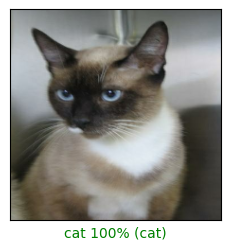

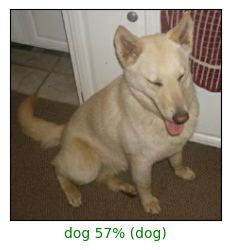

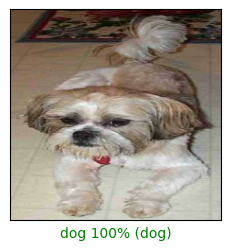

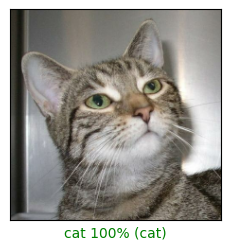

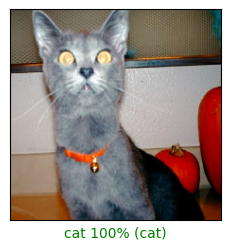

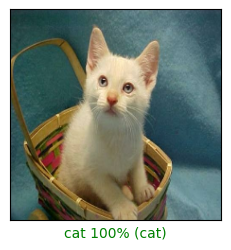

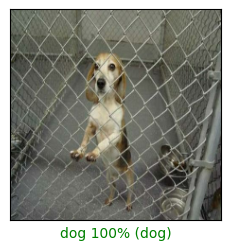

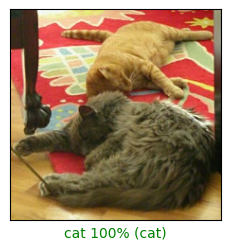

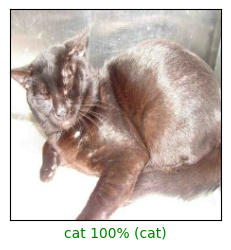

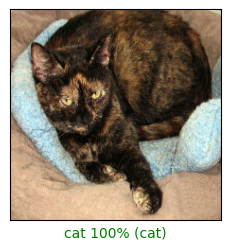

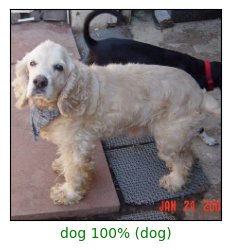

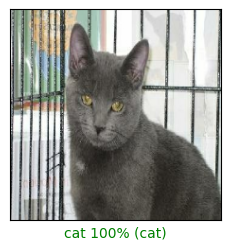

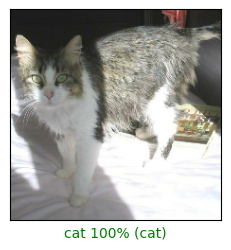

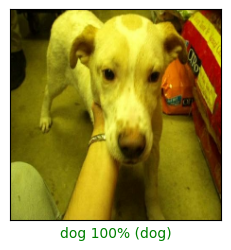

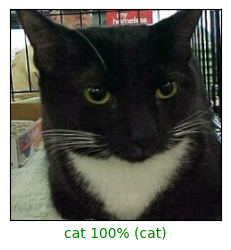

In [14]:
#@title Visualize the outputs each time { run: "auto" }
max_index = 15 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()